In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf_new
tf = tf_new.compat.v1
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Отключение подробного логирования (оставить только ошибки) другим способом
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# аргументы: новое название на диске, ссылка на источник, сразу разархивировать
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)

In [3]:
zip_dir = os.path.dirname(zip_dir)
zip_dir
# сохранилось сюда почему-то
# C:\Users\User\.keras\datasets

'C:\\Users\\User\\.keras\\datasets'

In [4]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'datasets\\cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
train_cats_dir

'C:\\Users\\User\\.keras\\datasets\\cats_and_dogs_filtered\\train\\cats'

In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [7]:
print('Кошек в тестовом наборе данных: ', num_cats_tr)
print('Собак в тестовом наборе данных: ', num_dogs_tr)
print('Кошек в валидационном наборе данных: ', num_cats_val)
print('Собак в валидационном наборе данных: ', num_dogs_val)
print('--')
print('Всего изображений в тренировочном наборе данных: ', total_train)
print('Всего изображений в валидационном наборе данных: ', total_val)

Кошек в тестовом наборе данных:  1000
Собак в тестовом наборе данных:  1000
Кошек в валидационном наборе данных:  500
Собак в валидационном наборе данных:  500
--
Всего изображений в тренировочном наборе данных:  2000
Всего изображений в валидационном наборе данных:  1000


In [10]:
BATCH_SIZE = 100
IMG_SHAPE = 150

In [11]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [12]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=validation_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
sample_training_images, _ = next(train_data_gen)

In [40]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    # flatten() : np.array([[1,2], [3,4]]) => array([1, 2, 3, 4])
    # flatten('F') : np.array([[1,2], [3,4]]) => array([1, 3, 2, 4])
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

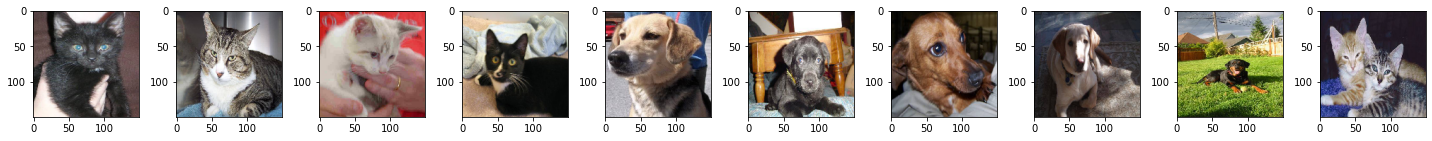

In [43]:
plotImages(sample_training_images[:10])

In [46]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), # Сверточный
    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Flatten(), # в одномерный
    tf.keras.layers.Dense(512, activation='relu'), # полносвязный
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [48]:
EPOCHS = 5
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val/float(BATCH_SIZE)))
)


Epoch 1/5
20/20 [==============================] - 54s 3s/step - loss: 0.6920 - accuracy: 0.5105 - val_loss: 0.6870 - val_accuracy: 0.5240

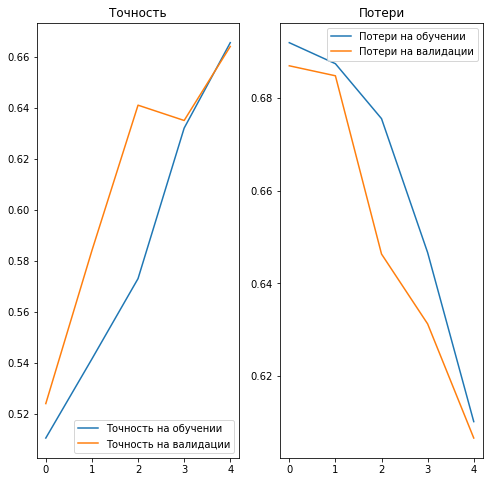

In [55]:
#acc = history.history['acc']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на обучении')
plt.plot(epochs_range, val_acc, label='Точность на валидации')
plt.legend(loc='lower right')
plt.title('Точность')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Потери на обучении")
plt.plot(epochs_range, val_loss, label="Потери на валидации")
plt.legend(loc='upper right')
plt.title('Потери')

plt.savefig('./foo.png')
plt.show()